In [1]:
load_ext cython

In [2]:
import cv2
import skimage.io
import numpy as np
from helpers import *
from classes import *
import matplotlib.pyplot as plt
    
img = skimage.io.imread('dock.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

with open('Pyramid_Arrays.pkl', 'rb') as f:
    pyr = pickle.load(f)

In [3]:
%%cython

cimport cython

@cython.wraparound(False)
@cython.boundscheck(False)
cpdef rectified_subtract(double[::1] a, double[::1] b, double[::1] result):
    cdef unsigned int x
    for x in range(len(a)):
        result[x] = (a[x] - b[x]) * (a[x] > b[x])

@cython.wraparound(False)
@cython.boundscheck(False)
cpdef rectified_subtract_RGB(double[:,::1] a, double[:,::1] b, double[:,::1] result):
    cdef unsigned int x,y
    for y in range(a.shape[0]):
        for x in range(a.shape[1]):
            result[y][x] = (a[y][x] - b[y][x]) * (a[y][x] > b[y][x])

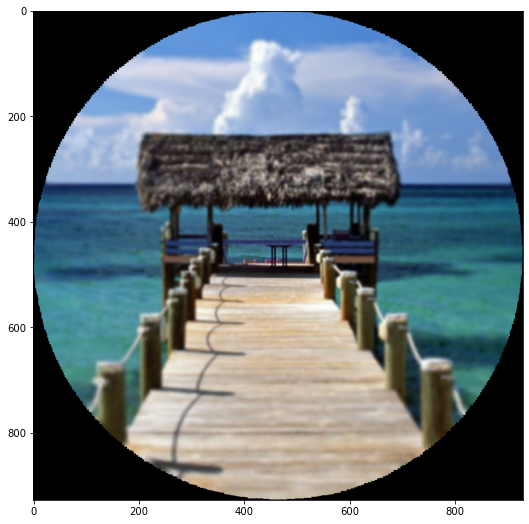

In [4]:
R = Retina('retina.pkl')
R.calibrate(img)
R.sample(img)
R.backProject()

plt.figure(figsize=(9,9))
plt.imshow(get_retinaBackProjected_RGB(R))
plt.show()
# plt.figure(figsize=(9,9))
# plt.imshow(get_retinaBackProjected_GRAY(R) ,cmap='gray')
# plt.show()

In [5]:
pyr_levels = []

for i in range(len(pyr)):
    index_array, coeff_array, size_array, input_dimension = pyr[i]
    pyr_levels.append(Pyramid_Level(coeff_array, index_array.astype('uint32'), size_array.astype('uint16'), input_dimension, 1))

In [6]:
img_vect = R.getResult()
dock_guassian = [img_vect]
for i in range(len(pyr_levels)):
    pyr_levels[i].calibrate(dock_guassian[-1])
    pyr_levels[i].sample(dock_guassian[-1].astype('uint8'))
    dock_guassian.append(pyr_levels[i].getResult())

In [7]:
def reconstruct_from(pyr_levels, level, img_vect):
    if img_vect.shape[-1] != pyr_levels[level].out_dim:
        return
    reconstruction = img_vect
    for i in range(level,-1,-1):
        pyr_levels[i].sampledVector = img_vect
        pyr_levels[i].backProject()
        img_vect = pyr_levels[i].backProjectedVector
    return img_vect

In [8]:
reconstructions = [dock_guassian[0]]
for i in range(len(pyr_levels)):
    reconstructions.append(reconstruct_from(pyr_levels, i, dock_guassian[i+1]))

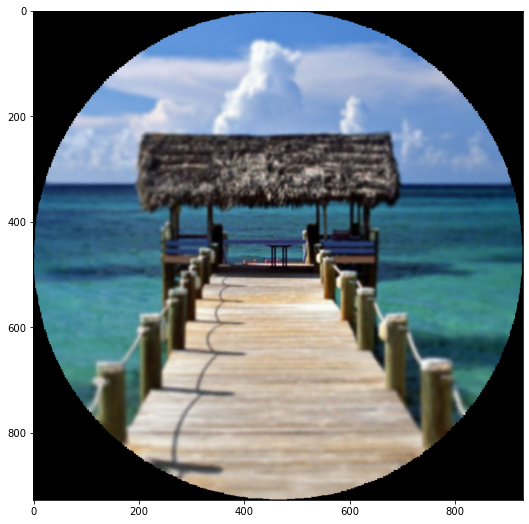

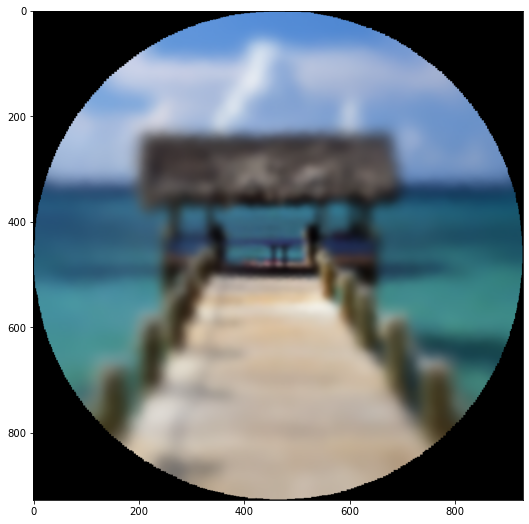

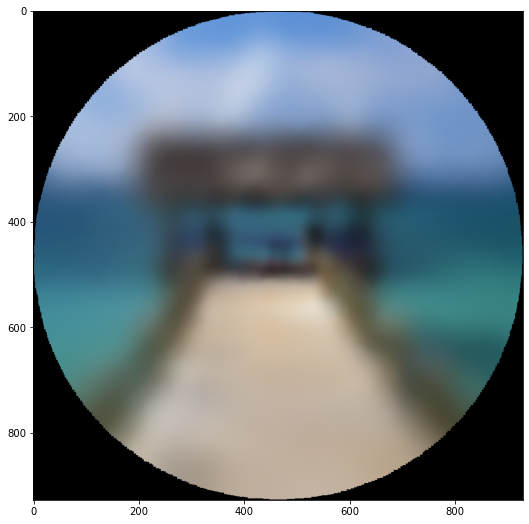

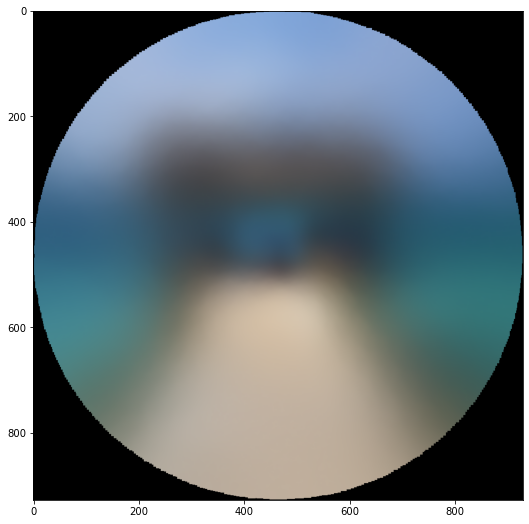

In [9]:
for i in range(len(reconstructions)):
    R.sampledVector = reconstructions[i]
    R.backProject()
#     plt.figure(figsize=(9,9))
#     plt.imshow(get_retinaBackProjected_GRAY(R) ,cmap='gray')
#     plt.show()
    plt.figure(figsize=(9,9))
    plt.imshow(get_retinaBackProjected_RGB(R))
    plt.show()

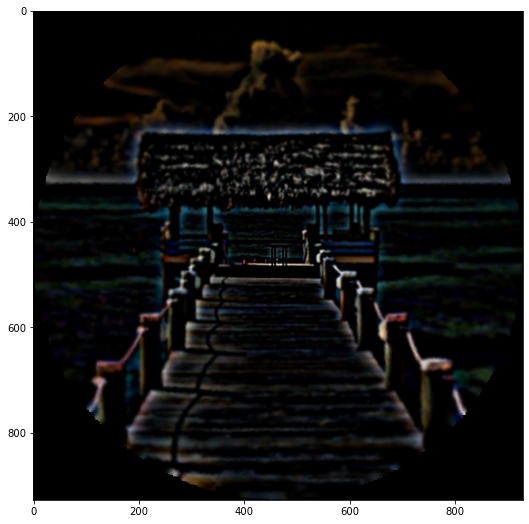

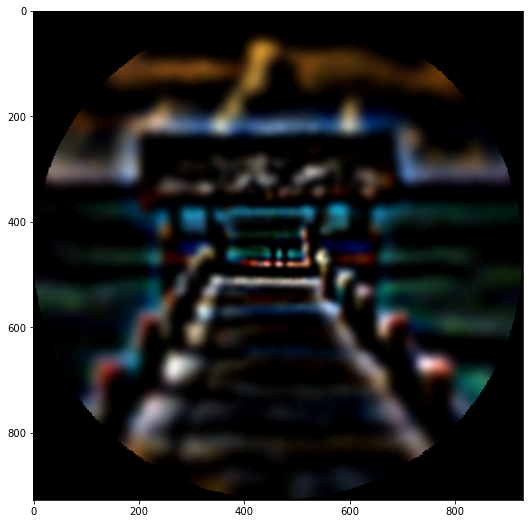

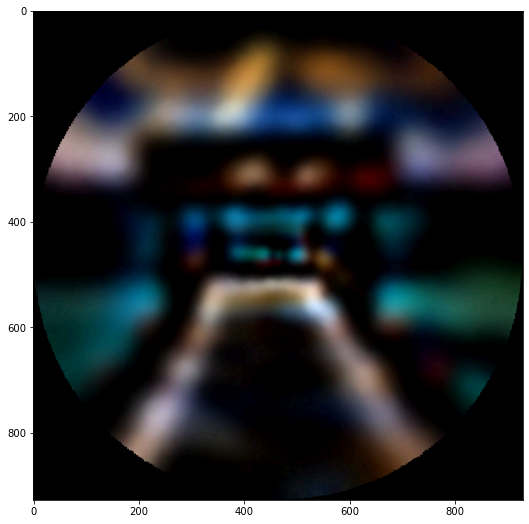

In [10]:
DoG = []

for i in range(len(pyr_levels)):
    pyr_levels[i].sampledVector = dock_guassian[i+1]
    pyr_levels[i].backProject()
    result = np.zeros(dock_guassian[i].shape, dtype='float64')
    rectified_subtract_RGB(dock_guassian[i], pyr_levels[i].backProjectedVector, result)
    
    if result.shape[-1] < R.sampledVector.shape[-1]:
        result = reconstruct_from(pyr_levels, i-1, result)
    DoG.append(result)
    R.sampledVector = result
    R.backProject()
    temp = get_retinaBackProjected_RGB(R)
    plt.figure(figsize=(9,9))
    plt.imshow(temp / temp.max())
    plt.show()